# Exploratory Data Science

Data exploration and understanding the task at hand is a fundamental step in the Machine Learning workflow.
In this notebook, we'll take an opportunity to explore the use case, data and models we'll be using.

We have been tasked with developing an application which can identify objects in static and live images. In this notebook we use a pre-trained machine learning model, and explore how it works on static photos. 

To begin, we import a range of python packages:

In [1]:
from os import environ

from boto3 import client
import cv2
import numpy as np
from onnxruntime import InferenceSession
from PIL import Image, ImageColor, ImageDraw, ImageFont
import torch
import torchvision

from classes import default_class_labels

import random
from matplotlib import pyplot as plt

## Import our image

In the next cell we import the image we want to test our model on.

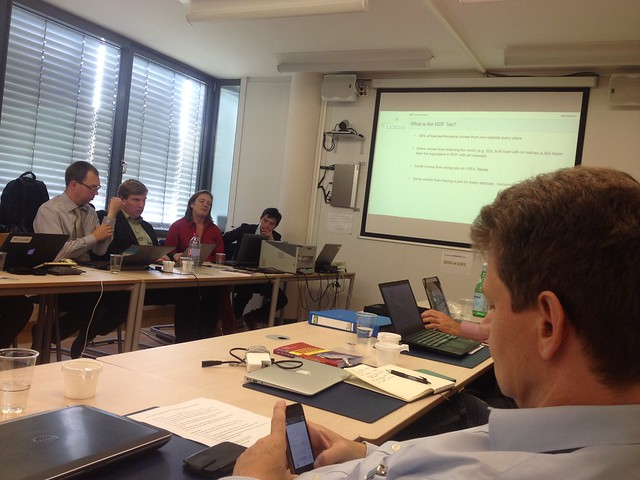

In [2]:
sample_image = 'sample-images/scene.jpg'
sample = Image.open(sample_image)
sample

This image shows a visual scene. We need to import the image as an array so the ONNX model we will use can process the image.

In [3]:
def transform(image_path, scaled_image_size=640):
    image = cv2.imread(image_path)
    image, ratio, dwdh = _letterbox_image(image, scaled_image_size, auto=False)
    image = image.transpose((2, 0, 1))
    image = np.expand_dims(image, 0)
    image = np.ascontiguousarray(image)
    im = image.astype(np.float32)
    im /= 255
    return im, ratio, dwdh


def _letterbox_image(
        im, image_size, color=(114, 114, 114), auto=True, scaleup=True, stride=32):

    shape = im.shape[:2]
    new_shape = image_size
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:
        r = min(r, 1.0)

    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]

    if auto:
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)

    dw /= 2
    dh /= 2

    if shape[::-1] != new_unpad:
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(
        im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color
    )

    return im, r, (dw, dh)

In [4]:
converted_image, scale_factor, padding = transform(sample_image)
converted_image

array([[[[0.44705883, 0.44705883, 0.44705883, ..., 0.44705883,
          0.44705883, 0.44705883],
         [0.44705883, 0.44705883, 0.44705883, ..., 0.44705883,
          0.44705883, 0.44705883],
         [0.44705883, 0.44705883, 0.44705883, ..., 0.44705883,
          0.44705883, 0.44705883],
         ...,
         [0.44705883, 0.44705883, 0.44705883, ..., 0.44705883,
          0.44705883, 0.44705883],
         [0.44705883, 0.44705883, 0.44705883, ..., 0.44705883,
          0.44705883, 0.44705883],
         [0.44705883, 0.44705883, 0.44705883, ..., 0.44705883,
          0.44705883, 0.44705883]],

        [[0.44705883, 0.44705883, 0.44705883, ..., 0.44705883,
          0.44705883, 0.44705883],
         [0.44705883, 0.44705883, 0.44705883, ..., 0.44705883,
          0.44705883, 0.44705883],
         [0.44705883, 0.44705883, 0.44705883, ..., 0.44705883,
          0.44705883, 0.44705883],
         ...,
         [0.44705883, 0.44705883, 0.44705883, ..., 0.44705883,
          0.44705883, 0.4

## Load in a model

The model we are going to use today is the Tiny YOLO v3 model, which you can download from the ONNX Model Zoo [here](https://github.com/onnx/models/tree/main/vision/object_detection_segmentation/tiny-yolov3). The model has been trained on the [COCO](https://cocodataset.org/#home) data set, and can recognise 80 types of objects. We begin by loading in the model.

The model is stored in an s3 bucket, and we connect to it using the `boto3` library. The `boto3` library was built into the object detection notebook image, which we selected from the spawner page. As such, it is already installed in our environment.

In [5]:
s3_endpoint_url = environ.get('AWS_S3_ENDPOINT')
s3_access_key = environ.get('AWS_ACCESS_KEY_ID')
s3_secret_key = environ.get('AWS_SECRET_ACCESS_KEY')
s3_bucket_name = environ.get('AWS_S3_BUCKET')

print('Imported s3 library')

Imported s3 library


In [6]:
s3 = client(
    's3', endpoint_url=s3_endpoint_url,
    aws_access_key_id=s3_access_key, aws_secret_access_key=s3_secret_key,
)
s3.download_file(s3_bucket_name, 'yolov5m.onnx', 'model.onnx')

print('Downloaded model.')

Downloaded model.


You should be able to see that this file has been added to your file directory on the left hand side of the screen.

Let's now use the model to run object detection on our sample image.

In [7]:
session = InferenceSession('model.onnx')
raw_result = session.run(
    [], {'images': converted_image}
)[0]
raw_result

array([[[4.9806452e+00, 6.0213099e+00, 7.8082066e+00, ...,
         2.7768016e-03, 4.5540929e-04, 1.0409057e-03],
        [8.7236528e+00, 6.7844505e+00, 1.2512697e+01, ...,
         2.2282004e-03, 6.8035722e-04, 1.3310313e-03],
        [1.9442766e+01, 7.4373121e+00, 1.5363033e+01, ...,
         2.5519729e-03, 6.7687035e-04, 1.8611550e-03],
        ...,
        [5.6290070e+02, 6.1740149e+02, 2.6809619e+02, ...,
         5.4388344e-03, 1.1925697e-03, 1.3801455e-03],
        [5.9325824e+02, 6.1818695e+02, 2.7251562e+02, ...,
         8.1136227e-03, 1.2816787e-03, 1.4536083e-03],
        [6.2182550e+02, 6.2435773e+02, 2.7916803e+02, ...,
         4.0339828e-03, 1.2651682e-03, 1.3931990e-03]]], dtype=float32)

In [8]:
def postprocess(
        prediction,
        class_labels,
        conf_thres=0.2,
        iou_thres=0.6,
        max_det=300,
        nm=0,
):
    prediction = torch.Tensor(prediction)
    bs = prediction.shape[0]
    nc = prediction.shape[2] - nm - 5
    xc = prediction[..., 4] > conf_thres

    max_wh = 7680
    max_nms = 30000

    mi = 5 + nc
    output = [torch.zeros((0, 6 + nm), device=prediction.device)] * bs

    results = []

    for xi, x in enumerate(prediction):
        x = x[xc[xi]]

        if not x.shape[0]:
            continue

        x[:, 5:] *= x[:, 4:5]
        box = _xywh2xyxy(x[:, :4])
        mask = x[:, mi:]
        conf, j = x[:, 5:mi].max(1, keepdim=True)
        x = torch.cat((box, conf, j.float(), mask), 1)[
            conf.view(-1) > conf_thres
        ]

        n = x.shape[0]
        if not n:
            continue
        elif n > max_nms:
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]
        else:
            x = x[x[:, 4].argsort(descending=True)]

        c = x[:, 5:6] * max_wh
        boxes = x[:, :4] + c
        scores = x[:, 4]
        i = torchvision.ops.nms(boxes, scores, iou_thres)
        if i.shape[0] > max_det:
            i = i[:max_det]

        output[xi] = x[i]

        final_boxes = np.array(output[xi][..., :4])
        final_boxes = final_boxes.round().astype(np.int32).tolist()
        cls_id = np.array(output[xi][..., 5], dtype=int)
        scores = np.array(output[xi][..., 4])
        names = [class_labels[id_] for id_ in cls_id]

        results.append([final_boxes, scores, names])

    return results


def _xywh2xyxy(x):
    y = torch.zeros_like(x) if isinstance(x, torch.Tensor) else np.zeros_like(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2
    y[:, 1] = x[:, 1] - x[:, 3] / 2
    y[:, 2] = x[:, 0] + x[:, 2] / 2
    y[:, 3] = x[:, 1] + x[:, 3] / 2
    return y


def _box_iou(box1, box2, eps=1e-7):
    (a1, a2), (b1, b2) = (
        box1.unsqueeze(1).chunk(2, 2),
        box2.unsqueeze(0).chunk(2, 2)
    )
    inter = (torch.min(a2, b2) - torch.max(a1, b1)).clamp(0).prod(2)
    return inter / ((a2 - a1).prod(2) + (b2 - b1).prod(2) - inter + eps)

In [9]:
class_labels = default_class_labels
result = postprocess(raw_result, class_labels)
result

[[[[0, 429, 38, 497],
   [377, 358, 484, 440],
   [165, 269, 225, 343],
   [61, 438, 103, 481],
   [1, 483, 173, 558],
   [109, 334, 123, 354],
   [360, 158, 591, 330],
   [2, 313, 69, 353],
   [355, 392, 378, 420],
   [31, 240, 113, 341],
   [103, 258, 161, 335],
   [299, 323, 343, 354],
   [354, 246, 638, 533],
   [243, 438, 351, 477],
   [162, 341, 175, 353],
   [180, 338, 194, 353],
   [472, 348, 489, 399],
   [254, 288, 283, 322],
   [284, 482, 315, 555],
   [0, 250, 50, 313],
   [376, 411, 402, 426],
   [374, 422, 405, 446],
   [223, 313, 265, 350],
   [119, 324, 177, 351],
   [308, 389, 357, 412],
   [230, 319, 297, 355],
   [0, 321, 35, 428],
   [190, 316, 202, 348],
   [256, 320, 301, 354],
   [343, 443, 434, 481],
   [375, 413, 404, 438],
   [0, 312, 12, 331],
   [221, 305, 250, 342],
   [0, 332, 8, 353]],
  array([0.90664953, 0.8680125 , 0.8584191 , 0.84136486, 0.8094789 ,
         0.8072518 , 0.7935903 , 0.7854446 , 0.78471386, 0.77520925,
         0.754623  , 0.72055084, 0

The model has returned arrays, each of which holds information about the detected objects. The information includes identifiers for the types of objects, coordinates locating the objects within the image, and detection scores, corresponding to how certain the model is about its prediction.

We can use a few functions to help us to superimpose the information in this dictionary onto the original image.

In [10]:
def draw_boxes(image_path, boxes, scores, labels, scaling, padding, class_labels):
    image = cv2.imread(image_path)  # Read image
    colors = {
        name: [
            random.randint(0, 255) for _ in range(3)
        ] for i, name in enumerate(class_labels)
    }
    for i, (x0, y0, x1, y1) in enumerate(boxes):
        box = np.array([x0, y0, x1, y1]).astype('float64')
        box -= np.array(padding*2)
        box /= scaling
        box = box.round().astype(np.int32).tolist()
        score = round(float(scores[i]), 3)
        name = labels[i]
        color = colors[name]
        name += ' '+str(score)
        cv2.rectangle(image, box[:2], box[2:], color, 2)
        cv2.putText(
            image,
            name,
            (box[0], box[1] - 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.75,
            [0, 255, 0],
            thickness=2
        )
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig = plt.gcf()
    fig.set_size_inches(24, 12)
    plt.axis('off')
    plt.imshow(img)

In [11]:
boxes = result[0][0]
scores = result[0][1]
labels = result[0][2]

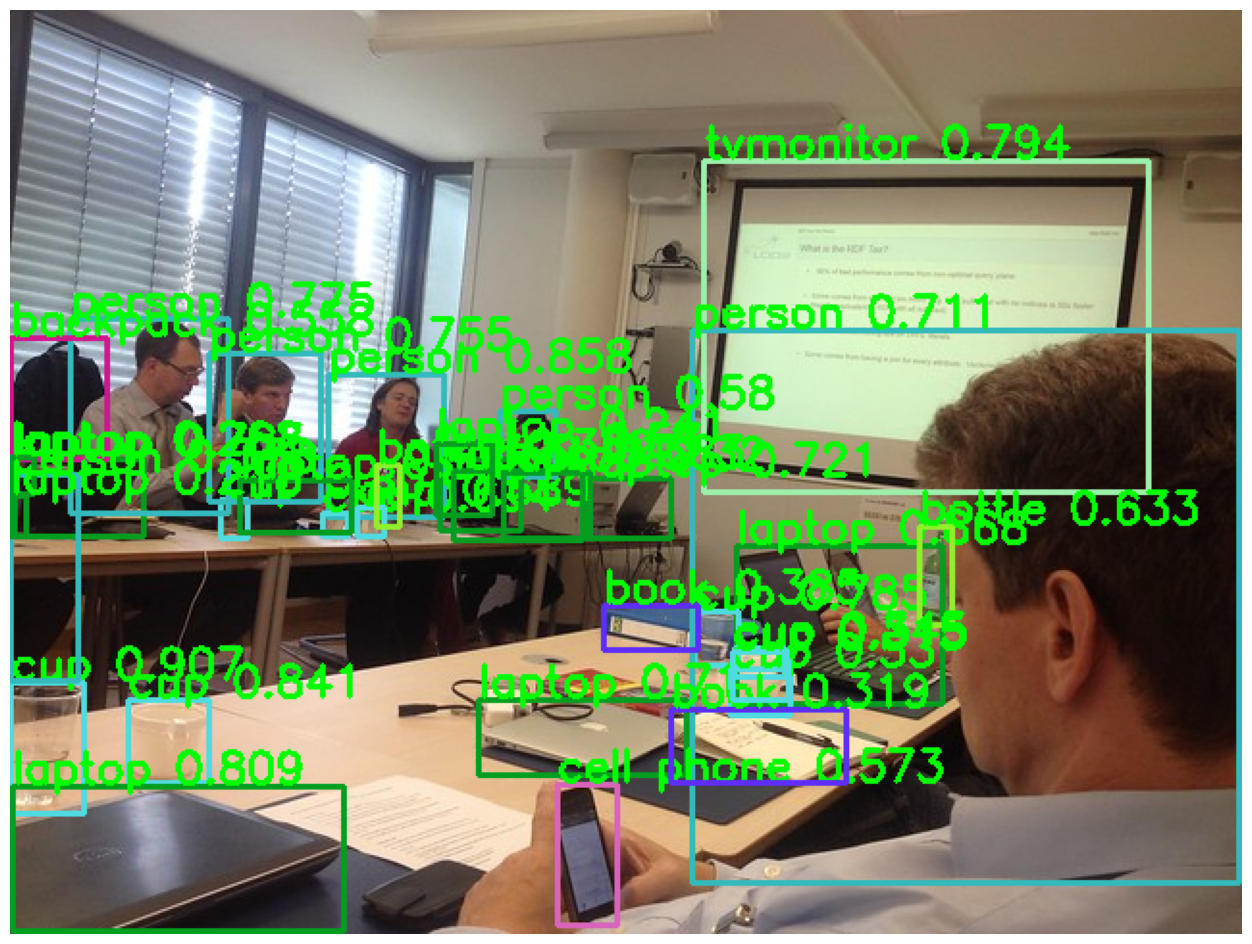

In [12]:
draw_boxes(sample_image, boxes, scores, labels, scale_factor, padding, class_labels)

Fantastic! So you've seen how we can use a pre-trained model to identify objects in images. In the next notebooks, we will deploy this model using RHODS Model Serving, which allows us to use it as part of a larger application.